<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">TD 2 - IFT 6285</div>

$\textbf{Auteur}$ : Adel Nabli


$\textbf{ID}$: 20121744

# Sujet:

**Sources**: http://www-labs.iro.umontreal.ca/~felipe/IFT6285-Automne2018/frontal.php?page=devoir2.html

Il s'agit d'un problème de classification: deux phrases (l'une en anglais, l'autre en français) sont-elles en relation de traduction? C'est un problème très étudié actuellement avec un impact dans des tâches comme la traduction automatique, l'acquisition de lexiques bilingues ou encore la détection de plagiat.


L'approche que vous aller prendre n'est pas prescrite. Vous pouvez par exemple calculer des features et entraîner un classificateur de manière supervisée. Un exemple d'une telle approche est décrit ici. Vous pouvez utiliser un réseau de neurone pour apprendre une représentation des phrases alimentant un classificateur. Une telle approche (avec code) est disponible ici. Vous pouvez aussi fonctionner de façon heuristique. Un baseline pourrait consister en le calcul d'un embedding par phrase (par exemple la moyenne des embeddings des mots d'une représentation déjà apprise (par exemple avec Word2Vec)) et d'ajuster un seuil au delà duquel le cosine de deux réprésentations indique une relation de traduction.

J'ai produit des exemples d'entraînement (et de test) en générant aléatoirement des paires de phrases à priori négatives. Il s'agit donc d'un problème simplifié dans la mesure ou les exemples négatifs, sont très probablement faciles à classer. Je générerai d'autres jeux de données en cours de projet.

À propos du jeu de test: vous pouvez le découper en dev (pour ajuster des métaparamètres) et en test pour réaliser vos expériences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import linalg
from collections import Counter
import re
from tqdm import tqdm
import umap
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
import spacy

nlp_en = spacy.load('en')
nlp_fr = spacy.load('fr')

# Loading the data given

* We think that the end point and the '\n' of each line brings artificial similarity between sentences, so we decided to remove them
* On enlève toutes les majuscules (car les embeddings que nous utilisons sont en minuscule)

In [38]:
data_fr = open('train.fr', encoding='utf-8')
data_en = open('train.en', encoding='utf-8')
data_test_en = open('test.en', encoding='utf-8')
data_test_fr = open('test.fr', encoding='utf-8')
data_final_fr = open('test_final.fr', encoding='utf-8')
data_final_en = open('test_final.en', encoding='utf-8')
Data_fr = []
Data_en = []
Data_test_fr = []
Data_test_en = []
Data_final_fr = []
Data_final_en = []

for lines in tqdm(data_fr):
    
    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_fr.append(line)

for lines in tqdm(data_en):
    
    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_en.append(line)

for lines in tqdm(data_test_fr):

    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_test_fr.append(line)

for lines in tqdm(data_test_en):
    
    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_test_en.append(line)

for lines in tqdm(data_final_fr):
    
    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_final_fr.append(line)

for lines in tqdm(data_final_en):
    
    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_final_en.append(line)

1038782it [00:20, 50300.94it/s]
1038782it [00:17, 59412.52it/s]
733789it [00:14, 49619.34it/s]
733789it [00:12, 56567.36it/s]
4500it [00:00, 70448.83it/s]
4500it [00:00, 81975.50it/s]


In [39]:
words_en = (tokens for sent in Data_en + Data_test_en + Data_final_en for tokens in sent)
words_fr = (tokens for sent in Data_fr + Data_test_fr + Data_final_fr for tokens in sent)
Voc_fr = Counter(words_fr)
Voc_en = Counter(words_en)

In [40]:
print('Taille du vocabulaire français: ', len(Voc_fr), '\n')
print('Taille du vocabulaire anglais: ', len(Voc_en), '\n')

Taille du vocabulaire français:  94363 

Taille du vocabulaire anglais:  58429 



# Loading the embeddings:

**Sources:** 

[1] **A. Joulin, P. Bojanowski, T. Mikolov, H. Jegou, E. Grave**, [*Loss in Translation: Learning Bilingual Word Mapping with a Retrieval Criterion*](https://arxiv.org/abs/1804.07745)

[2] **P. Bojanowski*, E. Grave*, A. Joulin, T. Mikolov**, [*Enriching Word Vectors with Subword Information*](https://arxiv.org/abs/1607.04606)


Nous allons utiliser des embeddings FastText anglais/français qui ont été alignés: les mots sémantiquement proches des deux langues ont une représentation vectorielle proches.

In [41]:
import io

def load_vectors(fname, voc):
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}

    for line in fin:
       
        tokens = line.rstrip().split(' ')
        
        if tokens[0] in voc:
            
            data[tokens[0]] = np.array(tokens[1:]).astype(float)
            
    return data

In [42]:
embeddings_fr = load_vectors('wiki.fr.align.vec', Voc_fr)
embeddings_en = load_vectors('wiki.en.align.vec', Voc_en)

In [43]:
print('Nombre de mots du vocabulaire français sans vecteur: ', -len(embeddings_fr) + len(Voc_fr), '\n')
print('Nombre de mots du vocabulaire anglais sans vecteur: ', -len(embeddings_en) + len(Voc_en))

Nombre de mots du vocabulaire français sans vecteur:  16011 

Nombre de mots du vocabulaire anglais sans vecteur:  6503


**Note**:

On se rend compte que tous les mots n'ont pas d'embeddings !
En effet, toutes les valeures numériques n'ont pas de vecteur associé. Cependant, il y a une dissymétrie claire entre le français et l'anglais: en inspectant, on se rend compte que les mots anglais non vectorisés sont presques exclusivement des valeures numériques et des noms propres, alors qu'en français certaines conjugaisons "exotiques" apparaissent dans les mots non vectorisés. On essait donc de diminuer le nombre de mots sans vecteurs en lemmatisant les mots non "pris en charge" et en essayant de voir si on peut leur attribuer un vecteur.

In [44]:
Mapping_words_fr = dict()

for words in tqdm(Voc_fr):
    
    Mapping_words_fr[words] = None
    
    if words in embeddings_fr:
        
        # The Mapping links a word to itself if the word has already a vector
        
        Mapping_words_fr[words] = words
        
    if words not in embeddings_fr:
        
        # If the word doesn't have a vector
        
        if re.search('[0-9]', words) is None:
            
            # if the word does not contain any decimal
            
            doc = nlp_fr(words)
            lemma = None
            
            for tokens in doc:
                
                # We find the lemma of the word
                
                lemma = tokens.lemma_
            
            if lemma in embeddings_fr:
                
                # if the lemma is known, we map the word to its lemma
                
                Mapping_words_fr[words] = lemma

100%|██████████████████████████████████████████████████████████████████████████| 94363/94363 [01:18<00:00, 1198.07it/s]


In [45]:
Mapping_words_en = dict()

for words in tqdm(Voc_en):
    
    Mapping_words_en[words] = None
    
    if words in embeddings_en:
        
        # The Mapping links a word to itself if the word has already a vector
        
        Mapping_words_en[words] = words
        
    if words not in embeddings_en:
        
        # If the word doesn't have a vector
        
        if re.search('[0-9]', words) is None:
            
            # if the word does not contain any decimal
            
            doc = nlp_en(words)
            lemma = None
            
            for tokens in doc:
                
                # We find the lemma of the word
                
                lemma = tokens.lemma_
            
            if lemma in embeddings_en:
                
                # if the lemma is known, we map the word to its lemma
                
                Mapping_words_en[words] = lemma

100%|██████████████████████████████████████████████████████████████████████████| 58429/58429 [00:22<00:00, 2634.50it/s]


In [46]:
cpt_fr = 0
cpt_en = 0

for words, mappings in Mapping_words_fr.items():
    
    if mappings is not None:
        
        cpt_fr +=1

for words, mappings in Mapping_words_en.items():
    
    if mappings is not None:
        
        cpt_en +=1

print('Nombre de mots du vocabulaire français sans vecteur après opération: ', -len(embeddings_fr) + cpt_fr, '\n')
print('Nombre de mots du vocabulaire anglais sans vecteur après opération: ', -len(embeddings_en) + cpt_en)

Nombre de mots du vocabulaire français sans vecteur après opération:  2123 

Nombre de mots du vocabulaire anglais sans vecteur après opération:  95


**Note**:

On a donc réussi à grandement diminuer le nombre de mots sans représentations vectorielles grâce à cette astuce.

# Présentation des différentes features utilisées:

## 1) Computing Discrete Fréchet Distance

Calculer la distance de fréchet est en général non trivial. Le cas des courbes polygonales est cependant solvable en $O(pq\log(pq))$. L'algorithme décrit originellement étant assez complexe à implémenter, nous nous sommes rabattus sur une approximation souvent utilisée, qui a l'avantage d'être plus rapide à calculer: la *discrete fréchet distance*

**Source:** 

[3] **T.Eiter, H.Mannila** [Computing Discrete Fréchet Distance](http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf)

![title](Algo_frechet_distance.png)

Nous implémentons en python l'algorithme présenté ci-dessus:

In [47]:
from scipy.spatial import distance as distance_

In [48]:
def distance(u,v):
    
    return(np.linalg.norm(u-v))
    #return(distance_.cosine(u,v))

In [49]:
def c(i, j, P, Q, ca):
    
    if ca[i,j] > -1:
        
        return(ca[i,j])
    
    elif i == 0 and j == 0:
        
        ca[i,j] = distance(P[0], Q[0])
    
    elif i > 0 and j == 0:
        
        ca[i,j] = np.max(np.array([c(i-1, 0, P, Q, ca), distance(P[i], Q[0])]))
    
    elif i == 0 and j > 0:
        
        ca[i,j] = np.max(np.array([c(0, j-1, P, Q, ca), distance(P[0], Q[j])]))
    
    elif i > 0 and j > 0:
        
        ca[i,j] = np.max(np.array([
            np.min(np.array([c(i-1, j, P, Q, ca), c(i-1, j-1, P, Q, ca), c(i, j-1, P, Q, ca)])),
            distance(P[i], Q[j])]))
    
    else:
        
        ca[i,j] = math.inf
    
    return(ca[i,j])

In [50]:
def compute_frechet_distance(P, Q):
    
    p = len(P)
    q = len(Q)
    ca = -1*np.ones((p,q))
    
    return(c(p-1, q-1, P, Q, ca))

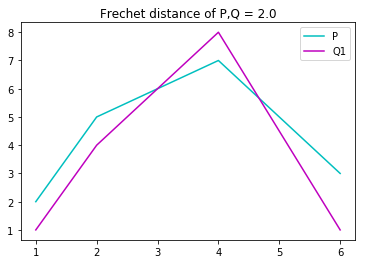

In [51]:
# Exemple 1

P = np.array([[1,2], [2,5], [4,7], [6,3]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

frechet_dist = compute_frechet_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Frechet distance of P,Q = %s' %str(frechet_dist))
plt.show()

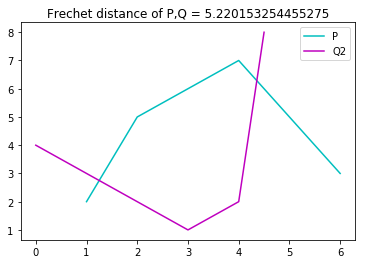

In [52]:
# Exemple 2

P = np.array([[1,2], [2,5], [4,7], [6,3]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

frechet_dist = compute_frechet_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Frechet distance of P,Q = %s' %str(frechet_dist))
plt.show()

On remarque bien que plus les courbes polygonales sont "semblables", plus la distance est faible....mais attention, la distance est **très sensible** aux pics/bruit !


On peut le remarquer avec les exemples suivants:

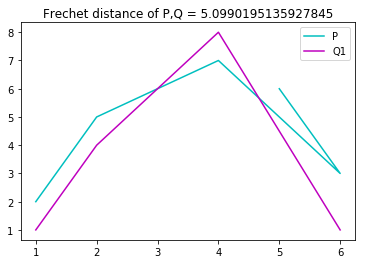

In [53]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

frechet_dist = compute_frechet_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Frechet distance of P,Q = %s' %str(frechet_dist))
plt.show()

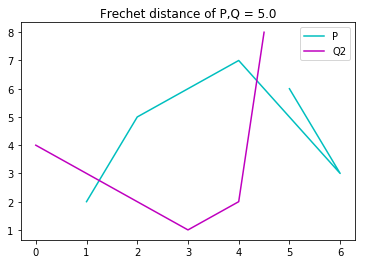

In [54]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

frechet_dist = compute_frechet_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Frechet distance of P,Q = %s' %str(frechet_dist))
plt.show()

En rajoutant à la fin un "pic", la courbe Q2 est maintenant plus proche de P au sens de Frechet !

## 2) Hausdorff distance between two paths

Nous allons utiliser l'implémentation de $\texttt{scipy}$ de la distance de hausdorff. Cette implémentation est cependant celle de la *directed hausdorff*, à savoir que la pseudo distance est asymétrique: $d(P,Q) \neq d(Q,P)$. Ainsi, cela nous oblige à prendre le maximum des deux distances comme distance finale.

In [55]:
from scipy.spatial.distance import directed_hausdorff

In [56]:
def compute_hausdorff_distance(P,Q):
    
    return(max(directed_hausdorff(P, Q)[0], directed_hausdorff(Q, P)[0]))

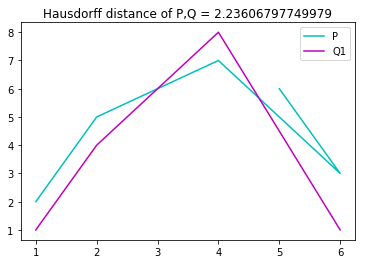

In [57]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

hausdorff_dist = compute_hausdorff_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Hausdorff distance of P,Q = %s' %str(hausdorff_dist))
plt.show()

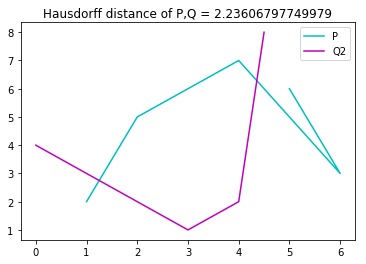

In [58]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

hausdorff_dist = compute_hausdorff_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Hausdorff distance of P,Q = %s' %str(hausdorff_dist))
plt.show()

Il semblerait donc qu'au sens de Hausdorff, ces deux courbes soient espacées de la même manière

## 3)  Analyse procustéenne

Nous allons encore une fois utiliser la librairie $\texttt{scipy}$ pour cela.

**Attention**:
Calculer la distance entre 2 séquences avec cette méthode requière des séquences de *même longeur*. Nous allons donc ajouter des vecteurs de 0 à la fin de la séquence la plus petite.

In [59]:
from scipy.spatial import procrustes

In [60]:
def compute_procrustes_disparity(P,Q):
    
    p = len(P)
    q = len(Q)
    dim = np.shape(P)[1]
 
    if p > q:
        
        zeros = np.zeros((p-q, dim))
        Q = np.concatenate((Q,zeros), axis=0)
    
    elif q > p:
        
        zeros = np.zeros((q-p, dim))
        P = np.concatenate((P,zeros), axis=0)
    
    mtx1, mtx2, disparity = procrustes(P, Q)
    
    return(disparity)

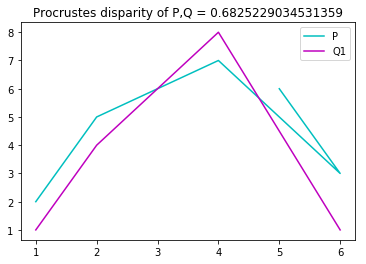

In [61]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

procrustes_disp = compute_procrustes_disparity(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Procrustes disparity of P,Q = %s' %str(procrustes_disp))
plt.show()

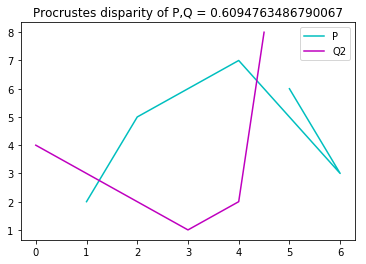

In [62]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

procrustes_disp = compute_procrustes_disparity(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Procrustes disparity of P,Q = %s' %str(procrustes_disp))
plt.show()

Avec cette mesure, Q2 est plus éloigné de P que Q1 l'est

## 4) Une mesure "maison" de la similarité entre 2 phrases

Nous allons cette fois utiliser une mesure créée de toute pièce pour comparer la similarité entre deux phrases anglaises/françaises.

* On part de cette slide du cours:

![title](proba_alignement.png)

Ainsi, cela nous dit que l'on peut s'attendre que les mots en relation de traductions entre une phrase anglaise et française qui sont une traduction l'une de l'autre sont situés plus ou moins à la même position relative dans leurs phrases respectives (pour une phrase anglais $e = e_1 \; e_2 .... e_t ... e_E$ en traduction avec une phrase française $f = f_1....f_t...f_F$, on peut s'attendre que la traduction du mot $e_t$ soit proche de $f_t$ dans la phrase française).

Ainsi, si on a 2 phrases en relation de traduction, on peut s'attendre qu'en regardant dans l'entourage du vecteur $f_t$, on trouve un vecteur dont le cosine est faible avec le vecteur $e_t$.

On construit alors la mesure suivante:

$home\_made\_distance = \dfrac{1}{2 \min(E,F)} \Big(\sum_{t \in [\![1, E]\!]} \min_{k \in entourage(t')} \big( d_{cosine}(f_k, e_t) \big) + \sum_{t \in [\![1, F]\!]} \min_{k \in entourage(t'')} \big( d_{cosine}(e_k, f_t) \big)\Big)$

Avec: $t' = \Big \lfloor \dfrac{t}{E}F \Big \rfloor$, $t'' = \Big \lfloor \dfrac{t}{F}E \Big \rfloor$ et $entourage(t)$ étant l'ensemble des mots qui sont dans la phrase entre les positions $t-n_{entourage}$ et $t+n_{entourage}$.

La normalisation par $\min(E,F)$ étant là pour pénaliser un gros grand écart de longeur entre les deux phrases.

Cela se traduit par l'algorithme suivant:

_________________
**ALGORITHME :**

* **Demande** de $n_{entourage}$
* **Initialisation**: $\Sigma_{cosine} =0$
* **Pour tout mot** $e_t$ dans $e$ (avec $t \in [\![1, E]\!])$, **faire**:

$\hspace{2cm}$ - **Calculer** $t' = \Big \lfloor \dfrac{t}{E}F \Big \rfloor$

$\hspace{2cm}$ - **Chercher** le mot dans l'entourage de $f_{t'}$ qui a le cosine le plus faible avec $e_t$ (on défini $cosine^t$ ce cosine minimal)

$\hspace{2cm}$ - $\Sigma_{cosine}$ += $cosine^t$

* **Pour tout mot** $f_t$ dans $f$ (avec $t \in [\![1, F]\!])$, **faire**

$\hspace{2cm}$ - **Calculer** $t'' = \Big \lfloor \dfrac{t}{F}E \Big \rfloor$

$\hspace{2cm}$ - **Chercher** le mot dans l'entourage de $e_{t''}$ qui a le cosine le plus faible avec $f_t$ (on défini $cosine^t$ ce cosine minimal)

$\hspace{2cm}$ - $\Sigma_{cosine}$ += $cosine^t$

* **Retourner** $\dfrac{\Sigma_{cosine}}{2\min(E,F)}$

_______


In [63]:
def home_made_measure(P,Q, n_neighborhood):
    
    sum_cosine = 0
    E = len(P)
    F = len(Q)
    
    for t in range(E):
        
        t_ = int((t/(E-1))*(F-1))
        
        borne_inf = t_ - n_neighborhood
        borne_inf = (borne_inf > 0)*borne_inf
        borne_sup = t_ + n_neighborhood
        borne_sup = borne_sup*(borne_sup < F) + F*(borne_sup >= F)
        
        min_cosine = math.inf
        
        for i in range(borne_inf, borne_sup):
            
            dist = distance_.cosine(P[t], Q[i])
            
            if dist < min_cosine:
                
                min_cosine = dist
                
        sum_cosine += min_cosine
    
    for t in range(F):
        
        t_ = int((t/(F-1))*(E-1))
        
        borne_inf = t_ - n_neighborhood
        borne_inf = (borne_inf > 0)*borne_inf
        borne_sup = t_ + n_neighborhood
        borne_sup = borne_sup*(borne_sup < E) + E*(borne_sup >= E)
        
        min_cosine = math.inf
        
        for i in range(borne_inf, borne_sup):
            
            dist = distance_.cosine(Q[t], P[i])
            
            if dist < min_cosine:
                
                min_cosine = dist
                
        sum_cosine += min_cosine
        
    sum_cosine = sum_cosine / (2*min(E,F))
    
    return(sum_cosine)

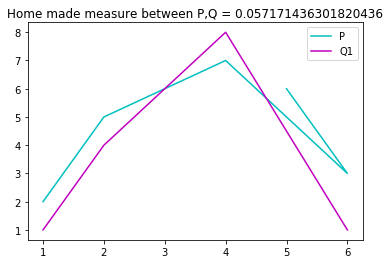

In [64]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

dist_home_made = home_made_measure(P,Q, 1)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Home made measure between P,Q = %s' %str(dist_home_made))
plt.show()

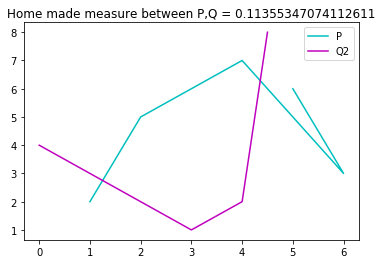

In [65]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

dist_home_made = home_made_measure(P,Q, 1)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Home made measure between P,Q = %s' %str(dist_home_made))
plt.show()

Avec cette distance maison, on arrive à dire que Q2 est plus éloigné de P que l'est Q1

## 5) Stacc inspired measure

Nous allons utiliser une sorte de variante de la mesure de Stacc en tirant partie de nos embeddings. Au lieu de créer les ensembles de "mots traduits", nous allons juste definir une boule pour la distance cosine, centrée sur le mot que l'on considère et dont le rayon $r$ est un hyperparamètre. Ainsi, on considèrera l'intersection de ces boules avec les embeddings de la phrase dans l'autre langue.

Dans la méthode originelle, on normalise le cardinal de l'intersection avec celui de l'union car on "crée" des traductions. Dans notre méthode, vu que l'on ne crée pas ces traductions (on regarde juste dans un voisinage), on choisira de normaliser plutôt par le nombre théorique maximal qu'il pourrait apparaître dans les sommes de cardinal (à savoir $E \times F$, atteint dans le cas de 2 phrases identiques constituées de répétition du même mot).

Finalement, notre mesure est définie par:

$RevisitedStacc = \dfrac{1}{2 E \times F} \Big (\sum_{t \in [\![1,E]\!]} |\mathcal{B}_{cosine}(e_t, r) \cap \{f_{t'} \}_{t' \in [\![1,F]\!]} | + \sum_{t' \in [\![1,F]\!]} |\mathcal{B}_{cosine}(f_{t'}, r) \cap \{e_{t} \}_{t \in [\![1,E]\!]} |\Big)$

In [66]:
def stacc_revisited(P,Q, r):
    
    card1 = 0
    
    for words in P:
        
        for mots in Q:
            
            card1 += (distance_.cosine(words, mots) < r)*1
    
    card2 = 0
    
    for mots in Q:
        
        for words in P:
            
            card2 += (distance_.cosine(words, mots) < r)*1
    
    return((card1 + card2)/(2*len(P)*len(Q)))

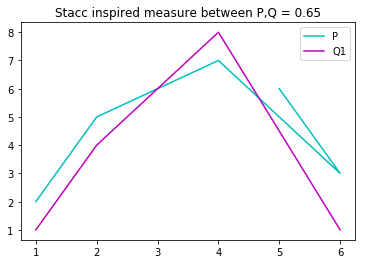

In [67]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

stacc_inspired = stacc_revisited(P,Q, 0.07)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Stacc inspired measure between P,Q = %s' %str(stacc_inspired))
plt.show()

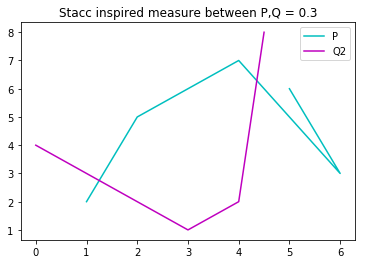

In [68]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

stacc_inspired = stacc_revisited(P,Q, 0.07)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Stacc inspired measure between P,Q = %s' %str(stacc_inspired))
plt.show()

Cela semble encore donner de bons résultats

## 6) Distance cosine des moyennes des phrases

Comme proposé dans le sujet, nous allons ajouter cette feature simple.

In [69]:
def compute_cosine_mean_embeddings(P,Q):
    
    E = np.mean(P, axis=0)
    F = np.mean(Q, axis=0)
    return(distance_.cosine(E,F))

# Main algorithm predicting whether the sentences are linked or not

On va ainsi:

* Représenter chaque phrase de notre dataset comme une suite d'embeddings, et ceux pour les deux langues
* Calculer pour ces deux suites les 6 features présentées
* Voir à la fin si cela nous permet de bien séparer nos données en deux ensembles distincts (en entraînant un classifieur par exemple)

**Calcul des features pour chaque paires de phrases**:

In [70]:
def compute_the_features(Data_en, Data_fr,
                         Mapping_words_en, Mapping_words_fr,
                         embeddings_en, embeddings_fr,
                         n_neighborhood, r_stacc):
    
    """Take the test sets and compute for each pairs of sentences the values of the 5 features"""
    
    n_sentences = len(Data_en)
    matrix_of_features = []
    
    for k in tqdm(range(n_sentences)):
        
        line_en = Data_en[k]
        line_fr = Data_fr[k]
        P_k = []
        Q_k = []
        features_k = [0]*6
        
        for words in line_en:
            
            word_2 = Mapping_words_en[words]
            
            if word_2 is not None:
                
                P_k.append(embeddings_en[word_2])
        
        P_k = np.array(P_k)
        
        for mots in line_fr:
            
            mot_2 = Mapping_words_fr[mots]
            
            if mot_2 is not None:
                
                Q_k.append(embeddings_fr[mot_2])
        
        Q_k = np.array(Q_k)
        
        try:
            features_k[0] = compute_frechet_distance(P_k, Q_k)
            features_k[1] = compute_hausdorff_distance(P_k,Q_k)
            features_k[2] = compute_procrustes_disparity(P_k,Q_k)
            features_k[3] = home_made_measure(P_k,Q_k, n_neighborhood)
            features_k[4] = stacc_revisited(P_k,Q_k, r_stacc)
            features_k[5] = compute_cosine_mean_embeddings(P_k,Q_k)
        except:
            features_k = features_k
        
        matrix_of_features.append(features_k)
    
    return(matrix_of_features)

**Choix d'un bon r_stacc**:

In [71]:
distance_.cosine(embeddings_fr['la'], embeddings_en['the'])

0.5560150889111046

In [72]:
distance_.cosine(embeddings_fr['fenêtre'], embeddings_en['king'])

1.1140877963513336

Un bon r_stacc semble donc être 0.7

In [73]:
matrix_of_features_train = compute_the_features(Data_test_en[0:5000] + Data_test_en[330270:335270] + Data_test_en[380000:385000]+ Data_test_en[727787:733787], Data_test_fr[0:5000] + Data_test_fr[330270:335270]+ Data_test_fr[380000:385000]+Data_test_fr[727787:733787],
                                          Mapping_words_en, Mapping_words_fr,
                                          embeddings_en, embeddings_fr,
                                          3, 0.7)

100%|████████████████████████████████████████████████████████████████████████████| 21000/21000 [36:52<00:00,  9.49it/s]


**Extraction du vecteur réponse y:**

In [74]:
data_y = open('test.y', encoding='utf-8')
y = []

for answers in data_y:
    
    y.append(int(answers))

In [42]:
727787-733787

-6000

In [75]:
y_extracted = y[0:5000] + y[330270:335270] + y[380000:385000] + y[727787:733787]

In [76]:
Data_final_en[2090]

['lancet', '2000', ',', '355(9198)', ';', '134', '138', '']

In [77]:
Data_final_fr[2090] == Data_final_en[2090]

True

In [78]:
matrix_of_features_test = compute_the_features(Data_final_en, Data_final_fr,
                                          Mapping_words_en, Mapping_words_fr,
                                          embeddings_en, embeddings_fr,
                                          3, 0.7)

100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [04:59<00:00, 11.50it/s]


**Visualisation des données après standardisation:**

In [79]:
X = StandardScaler().fit_transform(matrix_of_features_train)

In [80]:
X_final = StandardScaler().fit_transform(matrix_of_features_test)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y_extracted, test_size=0.04761, random_state=42)

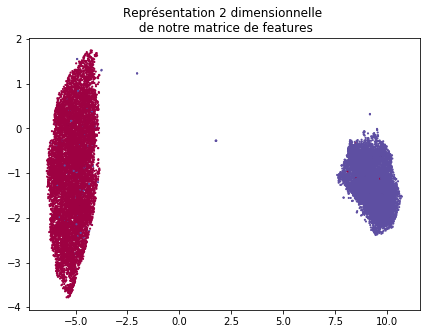

In [91]:
plt.figure(figsize=(7,5))
mapper = umap.UMAP(random_state=42, metric='manhattan', n_components=4).fit(X_train, y_train)
embedding_seuclidean_train = mapper.transform(X_train)
plt.scatter(embedding_seuclidean_train[:, 0], embedding_seuclidean_train[:, 1],  c=y_train, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre matrice de features')
plt.show()

**Commentaire**: Les features que nous avons calculées semblent donc bien séparer les données ! On attend donc de bons résultats en entraînant un classifieur.

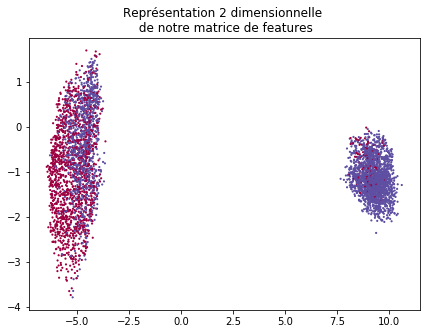

In [92]:
plt.figure(figsize=(7,5))
embedding_seuclidean = mapper.transform(X_final)
plt.scatter(embedding_seuclidean[:, 0], embedding_seuclidean[:, 1], c=y_true, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre matrice de features')
plt.show()

# Results and discussions:

**Entraînement d'un classifieur et résultats:**

In [123]:
100/21000*100 - 100

-4.761904761904773

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y_extracted, test_size=0.04761, random_state=42)

In [125]:
clf = RandomForestClassifier(n_estimators=450, n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)
y_pred  = clf.predict(X_test)
acc  = accuracy_score(y_test, y_pred)
print ('Accuracy with a Random Forest: ',acc)
pd.DataFrame(clf.feature_importances_, index=['Discrete Fréchet', 'Hausdorff', 'Procrustes', 'Home Made', 'Stacc inspired', 'Cosine of means'], columns=['Relative Importance of features'])

Accuracy with a Random Forest:  0.948


,Relative Importance of features
Discrete Fréchet,0.114220
Hausdorff,0.317534
Procrustes,0.035898
Home Made,0.405268
Stacc inspired,0.063837
Cosine of means,0.063242


**De l'innutilité de présenter beaucoup de données**:

In [93]:
clf = RandomForestClassifier(n_estimators=450, n_jobs=-1, random_state=0)
clf.fit(embedding_seuclidean_train, y_train)
y_pred_final = clf.predict(embedding_seuclidean)

In [36]:
file = open('test-NABLI-20.y')
y_pred_final = []

for answers in file:
    
    y_pred_final.append(int(answers[0]))

In [132]:
' '.join(Data_final_fr[0])

'les opinions exprimées dans ce document ne reflètent pas nécéssairement les vues de santé canada '

In [94]:
y_true = [1]*1000 + [0]*500 + [1]*1000 + [0]*1000 + [1]*1000
accuracy_score(y_true, y_pred_final)

0.7497777777777778

In [13]:
for k in range(500, 520):
    
    print(' '.join(Data_final_fr[k]), '\n', ' '.join(Data_final_en[k]), '\n', y_pred_final[k])

des délégations de plus de 150 états membres de l  organisation mondiale de la santé ont pris part aux négociations sur le libellé final de la convention  
 delegations from over 150 member states of the world health organization took part in the negotiations , seeking agreement on the final wording of the convention  
 1

le canada a participé activement aux négociations de la cclat depuis le début , en octobre 2000  
 canada has been actively participating in the fctc negotiations since they began in october 2000  
 1

ministère des affaires étrangères et du commerce 
 department of foreign affairs and international 
 1

fournir des services éducatifs réguliers au personnel médical , aux patients et aux familles 
 provide scheduled educational services to medical professionals , patients and their families 
 1

le programme dure en moyenne de trois à six mois , ce qui comprend une moyenne de neuf heures de rencontre avec le personnel du programme  
 the program spans an average of th

In [101]:
precision_score(y_test, y_pred)

0.9617341746387136

In [102]:
recall_score(y_test, y_pred)

0.9358288770053476

In [106]:
f1_score(y_test, y_pred)

0.9486046978518369

In [89]:
def predict_on_data(X, y, size_of_test):
    
    accuracy = []
    nb_train_examples = []
    
    for sizes in size_of_test:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sizes, random_state=41)
        clf = RandomForestClassifier(n_estimators=450, n_jobs=-1, random_state=0)
        clf.fit(X_train, y_train)
        y_pred  = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        nb_train_examples.append(int((1-sizes)*len(X)))

    plt.figure(figsize=(6,4))
    plt.plot(nb_train_examples, accuracy, color='m', label='Final accuracy = %s' %str(accuracy[-1]))
    plt.title("Evolution de l'accuracy en fonction \n de la taille du train set")
    plt.xlabel("Nombre de données d'entraînement (échelle log)")
    plt.xscale('log')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

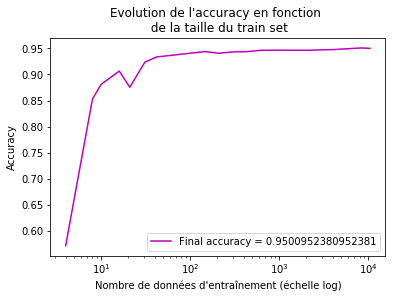

In [90]:
sizes = [0.9998, 0.9996, 0.9995, 0.9992, 0.999, 0.9985, 0.998, 0.995, 0.993, 0.99, 0.985, 0.98, 0.97, 0.95, 0.93, 0.9, 0.8, 0.6, 0.5]
predict_on_data(X, y_extracted, sizes)

**Observations**:

* On obtient une accuracy de 97% en n'utilisant que 1000 phrases à l'entraînement
* On remarque que la "meilleur" features est la distance que l'on a créé (40% d'importance). Ensuite la distance de Hausdorff (30%) et la distance de Fréchet (15%) sont celles de plus grande importance.

**Accuracy obtained if we use only one feature**:

In [91]:
def accuracy_each_feature_alone(X, y):
    
    d = np.shape(np.array(X))[1]
    accuracies = []
    
    for j in range(d):
        
        X_train, X_test, y_train, y_test = train_test_split(np.reshape(X[:,j], (len(X),1)), y, test_size=0.5, random_state=42)
        clf = RandomForestClassifier(n_estimators=450, n_jobs=-1, random_state=0)
        clf.fit(X_train, y_train)
        y_pred  = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    fig, ax = plt.subplots()   
    ax.barh(['Discrete Fréchet', 'Hausdorff', 'Procrustes', 'Home Made', 'Stacc inspired', 'Cosine of means'], accuracies, color='c')
    plt.xlabel('Accuracy')
    plt.title('Accuracies using only one feature')
    
    for i, v in enumerate(accuracies):
        
        ax.text(v-0.3, i-0.07, str(v), color='k')
    
    plt.show()

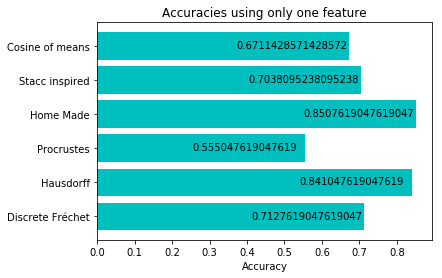

In [92]:
accuracy_each_feature_alone(X, y_extracted)

**Inspection des mauvaises prédictions**:

In [95]:
def inspect_bad_predictions(y_pred, y_test, Data_en, Data_fr, size_of_test, random_seed):
    
    Data_EN = Data_test_en[0:5000] + Data_test_en[330270:335270] + Data_test_en[380000:385000]+ Data_test_en[727787:733787]
    Data_FR = Data_test_fr[0:5000] + Data_test_fr[330270:335270]+ Data_test_fr[380000:385000]+Data_test_fr[727787:733787]
    
    e1, Data_test_EN, e2, e3 = train_test_split(Data_EN, y_extracted, test_size=size_of_test, random_state=random_seed)
    f1, Data_test_FR, f2, f3 = train_test_split(Data_FR, y_extracted, test_size=size_of_test, random_state=random_seed)
    
    indices = np.where(y_pred - y_test != 0)[0]
    
    for ids in indices:
        
        sentence_fr = str()
        sentence_en = str()
        
        for words in Data_test_EN[ids]:
            
            sentence_en += ' ' + str(words)
        
        for mots in Data_test_FR[ids]:
            
            sentence_fr += ' ' + str(mots)
        
        print('\n \n', sentence_fr, '\n', sentence_en, '\n', 'prédit:', y_pred[ids], '\n réel:', y_test[ids])

In [96]:
inspect_bad_predictions(y_pred, y_test, Data_test_en, Data_test_fr, 0.5, 42)


 
   l  année passée , toutefois , à l  initiative du parlement européen , on a cherché une nouvelle formule  
   at parliament  s suggestion , a different arrangement was arrived at last year  
 prédit: 0 
 réel: 1

 
   en outre , le voyageur est normalement informé de cette augmentation de prix   dès lors , on ne peut même pas appliquer la directive relative aux clauses abusives puisque chaque information ou publicité signale normalement le prix par personne ainsi que le supplément  
   moreover , travellers are normally made aware of the increased price , in that all advertising literature generally indicates the basic price and the supplement ; so nor can the directive on unfair contract terms be applied  
 prédit: 0 
 réel: 1

 
   chacun sait que la viande bovine accuserait des pertes irrémédiables si l  on ne procédait pas à une correction des prix sur le marché intérieur  
   it is well known that without a price adjustment , prospects for beef and veal on the home market are

   mais les mesures de libéralisation et de restructuration , auxquelles nous avons applaudi , ont également contribué à ces conséquences , durant la phase transitoire  
   however , these consequences are also contributing , in a transitional phase , to the liberalisation and restructuring measures which , with our backing , are being implemented  
 prédit: 0 
 réel: 1

 
   il est important que nous jouions un rôle fort et orienté vers l ’ avenir dans les prochaines négociations  
   it was an extremely good conference , but a single statement will not have a major impact on the acp  
 prédit: 1 
 réel: 0

 
   mais si nous continuons à répéter que les puissants états unis nous acculent dos au mur , et que nous n  avons pas la moindre marge de manoeuvre , tout le monde finira par le croire  
   there is a danger , however , that people will begin to believe all this constant talk of how america has got poor little europe pinned against the wall  
 prédit: 0 
 réel: 1

 
   adopter le

   in this new setting , the commission has made use of the instruments at its disposal  
 prédit: 1 
 réel: 0

 
   cette action peut être réalisée grâce à l ’ activation , et à la modification si nécessaire , du fonds de solidarité en faveur des régions et des pays touchés  
   without the input of community money , people who are old , sick or unemployed will not be able to exist  
 prédit: 1 
 réel: 0

 
   dans ces circonstances , la commission ne pourra pas retenir l ’ amendement 7  
   in general , i wish my report to be a progressive one  
 prédit: 1 
 réel: 0

 
   nous devons mettre en place des politiques nationales complémentaires efficaces et faire en sorte que les politiques demeurent communes à nous tous ; le financement commun doit également rester en vigueur  
   we must develop efficient and effective complementary national policies but we must ensure the policies remain common to us all and we must retain common financing  
 prédit: 0 
 réel: 1

 
   je suis ainsi ar

   the third objective set for 2004 by the commission , sustainable development , is therefore absolutely essential in the light of the union ’ s current economic situation  
 prédit: 1 
 réel: 0

 
   dans le cadre de l ’ achèvement du marché unique , il s ’ agit là d ’ une priorité  
   indeed , it is putting them to great expense without them having any say in the matter  
 prédit: 1 
 réel: 0

 
   cependant , je vote contre une hausse du budget , et contre l ’ amendement 18 , particulièrement peu judicieux dans sa visée néocolonialiste d ’ exporter des jugements et des valeurs  
   that applies to the european council , the committee on regional policy , transport and tourism and the committee on the environment , public health and consumer policy  
 prédit: 1 
 réel: 0

 
   enfin , la commission considère que sa proposition visant à amender le règlement n ° 1683 du conseil respecte toutes les questions relatives à la protection des données  
   today , the european parliament ag

   quoi qu  il en soit , je peux vous promettre qu  en ce qui concerne la présidence allemande , nous sommes tout à fait prêts à remplir les devoirs d  information qui nous échoient et j  espère une bonne collaboration dans ce domaine  
   in any case , on behalf of the german presidency , i can only assure you that we will be very glad to comply with our duty of information , and i accordingly look forward to successful cooperation  
 prédit: 0 
 réel: 1

 
   cela devrait , en définitive , renforcer la confiance du consommateur dans le marché intérieur et permettre aux entreprises , en particulier les petites et moyennes entreprises , de faire du commerce plus facilement au sein de l  ue  
   i would like to highlight an aspect which i believe to be particularly important , and that is that chile has concluded this association agreement with the european union before concluding its agreement with the united states  
 prédit: 1 
 réel: 0

 
   alors le conseil a adopté une position co

   by speaking for more than half an hour , the commissioner tried to make all this sound better than it is   but the whole plan will be upset by the angry and orchestrated response of the farming community  
 prédit: 0 
 réel: 1

 
   ( en ) monsieur le président , je voudrais vous demander un petit service  
   mr staes , i am sorry for having left some of your questions out  
 prédit: 1 
 réel: 0

 
   face à l  autocratie , à la corruption , à la fraude électorale et aux coups d  état illégaux , l  ue reste bien trop souvent silencieuse  
   the au is all too often silent in the face of autocracy , corruption , electoral fraud and illegal coups d  état  
 prédit: 0 
 réel: 1

 
   c  est pourquoi nous avons tenté , par ce paquet législatif , de donner un sens plus significatif au marquage ce , d  introduire des sanctions en cas de non respect , de renforcer les règles relatives à l  apposition du marquage et de renforcer sensiblement le système de contrôle du marché  
   it falls w

   mr brok , allow me to point out one thing , which is something i also want to say to certain colleagues  
 prédit: 0 
 réel: 1

 
   la stabilité de cette région est extrêmement importante pour l  ensemble de l  union européenne , et ne peut être atteinte que dans le cadre d  une perspective européenne  
   everybody is convinced of the important role that financial security , including but not limited to insurance , can play in the implementation of the directive  
 prédit: 1 
 réel: 0

 
   dans le cadre de ce débat , on commence même à se demander s  il ne faudrait pas passer à l  étape suivante  
   the question that now begins to arise in the debate is whether we should go one stage further  
 prédit: 0 
 réel: 1

 
   le projet " ue pilot " a été lancé en 2008 , sa tâche consistant à garantir une compréhension et une application correcte de la loi  
   the eu pilot programme was launched in 2008 so that the law would be understood and applied correctly  
 prédit: 0 
 réel: 1



   pour se développer et prospérer , la « flexicurité »   pour employer l ’ un des mots favoris de m  barroso   et l ’ innovation sont indispensables à l ’ europe  
   i have no doubt this move is directly related to the president of the commission  s call for the development of a   europe of the regions    
 prédit: 1 
 réel: 0

 
   la présentation préalable d  un rapport permettrait d  avoir en plénière un véritable débat  
   if a report was presented beforehand , there could be a real debate in the house  
 prédit: 0 
 réel: 1

 
   l  entrée en fonction d  europol est un objectif qui tient particulièrement à cur à la présidence  
   the german presidency is particularly concerned to see europol take up its duties  
 prédit: 0 
 réel: 1

 
   le rapport entre les tâches de l  union européenne en matière de politique du logement , par exemple , et ce que nous demandons à présent , pose problème  
   it is a question of coping both with the preparations prior to enlargement and with

   il faut finaliser les négociations , heureusement déjà fort avancées , en vue d  un accord d  association avec la norvège et l  islande  
   negotiations with norway and iceland , which i am pleased to say have already made great progress , are to be finalised by means of an association agreement  
 prédit: 0 
 réel: 1

 
   c  est d  ailleurs lors de ces réformes que , pour la première fois , une ligne de crédit a été ajoutée , qui n  était que fort peu liée à la politique de marché et de prix en tant que telle   aujourd  hui encore , divers nouveaux chapitres ont été insérés  
   just as the macsharry reforms for the first time introduced a budget line which had little to do with policy on markets and prices as such , this time too all manner of new chapters are being added  
 prédit: 0 
 réel: 1

 
   pour ces raisons , il est nécessaire que le conseil de sécurité de l ’ onu intervienne  
   for us , it is , however , these very things that go to the heart of the general interest

   commissioner , we will still , in future , need the european networks to draw up new guidelines and improve existing ones , for only by these means will we achieve equally high standards of screening across the eu  
 prédit: 1 
 réel: 0

 
   enfin , il pourra ainsi , dans le respect de l  indépendance de la banque centrale européenne , être un utile contrepoids dans la conduite d  une politique économique orientée sur la croissance et l  emploi  
   the swedish christian democrats emphasise the need for coordination and cooperation within the european railways sector , but still question the need for a permanent agency to deal with the sector  
 prédit: 1 
 réel: 0

 
   mais je dois vous demander de bien vouloir comprendre qu  il faut attendre la conclusion de l  agenda 2000 pour être plus précis à ce sujet et pour pouvoir entamer la mise en uvre de ses objectifs  
   however , i must ask you to appreciate that we cannot be more precise about this until agenda 2000 has been conclu